In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imaplib
import email
import os
import poplib
import getpass

import plotly
import plotly.plotly as py
from plotly import tools
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from os import listdir
from os.path import isfile, join
 


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [168]:
#read from xl csv...
df = pd.read_excel('CaraHittahV2.xlsx', sheet_name=None, ignore_index = False, sort=True)
cdf = pd.concat(df.values())

In [169]:
#the CSV is a bit of a mess - we take first row as the header, and start from row 2
#cdf.head()
cdf.columns = cdf.iloc[1, :]
cdf = cdf.iloc[2:, :]

In [170]:
#drop some columns - interesting way to do it by subsetting columns

hx = cdf[[                 'AB',                'Date',            
         'Strike Zone Width',                  'BV',               'POI X',
              'Bat Material',     'Impact Momentum',        'Horiz. Angle',
                                         'Dist',             'P. Type',
        'Strike Zone Bottom',                 'Pts',                'Velo',
         'Vertical Distance',               'Pitch',                'User',
                     'POI Y',                 'Res',   'Trigger to Impact',
                         
                         'Horizontal Distance',     'Strike Zone Top',
                'Hand Speed',                  'LA',          'Time Stamp',
               'Strike Zone',                                  'POI Z',
                        'AA',                'Type',  'Pitch Angle', 
          'Batting', 'Level', 'Barrel'  ]]


In [171]:
def removefloats(row):
    if type (row['User']) == float:
        return "dummy"
    else:
        return(row['User'])

In [172]:
## We are not using thing function ... it has a small problem 
#the function reads in an XLS file with multiple sheets, and returns a dateframe
#function doesnt do much validation that each sheet uses consistent format
#see helper documents for format of each sheet
def readdata(filename):
    xlsx = pd.ExcelFile(filename)

#initialize hitters_sheet
    hitters_sheets = []
    nsheet = xlsx.parse(xlsx.sheet_names[0])
    cols = nsheet.iloc[1, :]
    print(nsheet.shape, len(cols))
    nsheet.columns = cols
    nsheet = nsheet.iloc[2:,]
    hitters_sheets.append(nsheet)

    for isheet in range(1, len(xlsx.sheet_names)):
        nsheet = xlsx.parse(xlsx.sheet_names[isheet])
        if nsheet.shape[0] < 2:
            continue
        #print(nsheet.shape)
        nsheet = nsheet.iloc[2:, 0:53]
        #nsheet = nsheet.iloc[1:,]
        nsheet.columns = cols
        hitters_sheets.append(nsheet)
    
    hitters = pd.concat(hitters_sheets)
    return(hitters)


In [173]:
hx2 = hx.rename(index=str,columns={'POI X':'X','POI Y':'Y'}) 
hx2['User'] = hx2.apply(removefloats,axis=1)
hx2 = hx2[(hx2.User!='User') & (hx2.User != 'dummy')]
hx2 = hx2[hx2.User.notna()]

In [174]:
hx2.shape

(12163, 32)

In [175]:
Barrel = hx2.Barrel.dropna()
Barrel.count()
Barrel.sum()/Barrel.count()

0.13059604934011904

In [176]:
#return average, max, min velocity by strikezone
def velobyzone(df, zone):
    dfx = df[df['Strike Zone']== zone]
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    n = round(dfx.Velo.min(),1)
    return a, m
    

In [177]:
#function returns flybal, ground ball, line drive % by strike zone grid

def hittingbyzone(df, zone):
    
    if zone != 0:
        dfx = df[df['Strike Zone']== zone]
    else:
        #overall statistics
        dfx = df
    
    if dfx.shape[0] == 0:
        gb = 0.0
        ld = 0.0
        fb = 0.0
        a = 0.0
        m = 0.0 
        tup = (fb, gb, ld, a, m)
        return tup
    
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    #n = round(dfx.Velo.min(),1)
    
    dfx = dfx.groupby(['Type']).count()
    y = dfx.shape
    s = dfx.iloc[:, 0].sum()
    if y[0] < 2:
        gb = 0.0
    else:
        gb = round(dfx.iloc[1,0]/s, 1)
    if y[0] < 3:
        ld = 0.0
    else:             
        ld = round(dfx.iloc[2,0]/s, 1)
    fb = round(dfx.iloc[0,0]/s, 1)
    
    tup = (fb, gb, ld, a, m)
    return tup

In [178]:
maxdutto = hx2[hx2.User == 'Max Dutto']
#maxdutto.groupby('Strike Zone').Velo.agg(my_mean)

In [179]:
hittingbyzone(maxdutto,2)

(0.7, 0.3, 0.0, 80.7, 85.8)

In [192]:
def gethitterstats(df, hittername):
    
    alist = []
    cols  = ['Fly Balls', 'Ground Balls', 'Line Drive', 'AvgExitVelo', 'Max Exit Velo']
    idx = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7', 'Zone 8', 'Zone 9', 'Overall']
    if hittername != 'All':
        dfx = df[df.User == hittername]
    else:
        dfx = df
    
    for i in range(1, 10):
        tup = hittingbyzone(dfx, i)
        alist.append(tup)
        
    tup = hittingbyzone(dfx,0)
    alist.append(tup)
        
    #print (alist)
    
    hstats = pd.DataFrame(alist, index = idx, columns = cols)
    return(hstats)

In [193]:
hstats = gethitterstats(hx2, 'Max Dutto')
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo
Zone 1,0.0,0.0,0.0,0.0,0.0
Zone 2,0.7,0.3,0.0,80.7,85.8
Zone 3,0.0,0.0,0.0,0.0,0.0
Zone 4,0.6,0.2,0.2,84.4,93.7
Zone 5,0.6,0.0,0.4,79.4,96.6
Zone 6,0.4,0.4,0.1,88.1,95.4
Zone 7,0.4,0.3,0.3,86.7,98.8
Zone 8,0.2,0.2,0.5,87.4,98.6
Zone 9,0.3,0.1,0.6,86.1,96.9
Overall,0.4,0.2,0.4,84.1,98.8


In [182]:
def homeplate():
    plt.figure(figsize=(8,12),dpi=80)
    plt.xlim(-18,18)
    plt.ylim(0,60)

    xmin = -8.5
    xmax = 8.5
    ymin = 23.1
    ymax = 44.6
    deltax = (xmax-xmin)/3
    deltay = (ymax-ymin)/3

    xtick = [xmin, xmin+deltax, xmin+(2*deltax), xmax]
    ytick = [ymin, ymin+deltay, ymin+(2*deltay), ymax]

    X1 = np.linspace(xmin,xmax,4)
    Y1 = np.linspace(ymin,ymax,4)
    Y2 = np.linspace(ymin,ymin,4)
    X2 = np.linspace(xmin,xmin,4)
    X3 = np.linspace(xmax,xmax,4)
    Y3 = np.linspace(ymax,ymax,4)


    X4 = np.linspace(xtick[1],xtick[1],4)
    X5 = np.linspace(xtick[2],xtick[2],4)
    Y4 = np.linspace(ytick[1],ytick[1],4)
    Y5 = np.linspace(ytick[2],ytick[2],4)


    plt.plot(X1,Y2,c='black')
    plt.plot(X2,Y1,c='black')
    plt.plot(X1,Y3,c='black')
    plt.plot(X3,Y1,c='black')


    plt.plot(X4,Y1,c='black',linestyle= '--')
    plt.plot(X5,Y1,c='black',linestyle= '--')
    plt.plot(X1,Y4,c='black',linestyle= '--')
    plt.plot(X1,Y5,c='black',linestyle= '--')
    deltax2 = deltax * 0.6
    deltay2 = deltay * 0.6
    x0 = xmin - deltax2
    x6 = xmax + deltax2
    y0 = ymin - deltay2
    y6 = ymax + deltay2
    yhalf = (ymax+ymin) * 0.5
    xhalf = (xmax + xmin) * 0.5
    
    X0 = np.linspace(x0, x6, 4)
    X6 = np.linspace(x0, x0, 4)
    X7 = np.linspace(x6, x6, 4)
    Y0 = np.linspace(y0, y6, 4)
    Y6 = np.linspace(y0, y0, 4)
    Y7 = np.linspace(y6, y6, 4)
    
    X10 = np.linspace(x0, xmin, 4)
    X11 = np.linspace(xmax, x6, 4)
    X12 = np.linspace(xhalf, xhalf, 4)
    Y10 = np.linspace(y0, ymin, 4)
    Y11 = np.linspace(ymax, y6, 4)
    Y12 = np.linspace(yhalf, yhalf, 4)
    
    plt.plot(X0, Y6, c='red')
    plt.plot(X0, Y7, c='red')
    plt.plot(X6, Y0, c='red')
    plt.plot(X7, Y0, c='red')
    
    plt.plot(X10, Y12, c='red')
    plt.plot(X11, Y12, c='red')
    plt.plot(X12, Y10, c='red')
    plt.plot(X12, Y11, c='red')



In [183]:
def analyze(hx2,username,date1,date2,v1,v2):
    
    #subset by player .. 
    hnew = hx2[hx2.User == username]
    
    Vmax = 90
    Vlow = 83
   
    LAopt1 = 10
    LAopt2 = 30
    LAbad = 0
    
    
    homeplate()
    #plt.scatter(hnew.X,hnew.Y)
    #h1 = hnew[(hnew.LA<5)]
    h0  = hnew[(hnew.LA>10)&(hnew.LA < 30)]
    h00 = h0[h0.Velo >= 90]
    h01 = h0[(h0.Velo <90) & (h0.Velo >83)]
    h02 = h0[h0.Velo <= 83]
    
    h1 = hnew[(hnew.LA > 0) & (hnew.LA <10)]
    h10 = h1[h1.Velo>=90]
    h11 = h1[(h1.Velo>83) & (h1.Velo <90)]
    h12 = h1[h1.Velo< 83]
    
    h2 = hnew[hnew.LA < 0]
    h20 = h2[h2.Velo >= 90]
    h21 = h2[(h2.Velo > 83) & (h2.Velo <90)]
    h22 = h2[h2.Velo <= 83]
    
    h3 = hnew[hnew.LA > 30]
    h30 = h3[h3.Velo >= 90]
    h31 = h3[(h3.Velo > 83) & (h3.Velo <90)]
    h32 = h3[h3.Velo <= 83]
    
    #x = hnew.X
    #y=hnew.Y
    plt.scatter(h00.X,h00.Y, c='darkgreen',s=30, label='EV>90, LA 10-30')
    plt.scatter(h01.X, h01.Y, c ='green',s=30,marker='*', label='EV 83-90, LA 10-30')
    plt.scatter(h02.X, h02.Y, c='limegreen', s=30, marker='v', label='EV<83, LA10-30')
     
    plt.scatter(h10.X,h10.Y, c='darkblue',s=30, label='EV>90, LA 0-10')
    plt.scatter(h11.X, h11.Y, c ='mediumblue',s=30,marker='*', label='EV 83-90, LA 0-10')
    plt.scatter(h12.X, h12.Y, c='blue', s=30, marker='v', label='EV<83, LA 0=10') 
    
    plt.scatter(h20.X,h20.Y, c='red',s=30, label='EV>90, LA <0')
    plt.scatter(h21.X, h21.Y, c ='darkred',s=30,marker='*', label='EV 83-90, LA <0')
    plt.scatter(h22.X, h22.Y, c='orangered', s=30, marker='v', label='EV<83, LA <0') 
    
    plt.scatter(h30.X,h30.Y, c='magenta',s=30, label='EV>90, LA >30')
    plt.scatter(h31.X, h31.Y, c ='fuchsia',s=30,marker='*', label='EV 83-90, LA >30')
    plt.scatter(h32.X, h32.Y, c='orchid', s=30, marker='v', label='EV<83, LA >30')
    
    plt.xlabel('Horizontal Location' )
    plt.ylabel('Vertical Location')
    plt.title(username)
    
    #return hnew
    plt.legend()
    plt.show()
    
    hstats = gethitterstats(hnew, 'All')
    return hstats

In [184]:
def doheatmaps(hstats):
    Z = hstats.loc[:, 'AvgExitVelo']
    Z = Z.tolist()
    Z = [Z[0:3], Z[3:6], Z[6:9]]
    LDz = hstats.loc[:, 'Line Drive']
    LD = LDz.tolist()
    LD = [LD[0:3], LD[3:6], LD[6:9]]
    hitterheatmap(Z,'Average Exit Velocity Heatmap')
    hitterheatmap(LD, 'Line Drive % Heatmap')

In [185]:
def hitterheatmap(Z, labelstring):
#fig = FF.create_annotated_heatmap(d, colorscale='Viridis')

#plotly.figure_factory.create_annotated_heatmap(d) 
#py.iplot(fig, filename='numpy-reshape-1')

    X = ['Left', 'Mid', 'Right']
    Y = ['Bottom', 'Mid', 'Top']

    trace = go.Heatmap(z=Z,x=X,y=Y)
    #Q = [ [12,14,8], [21,33,44],[8,7,11] ]
    #trace2 = go.Heatmap(z=Q, x=X, y=Y)

    #fig = tools.make_subplots(rows=1, cols=2)
    #fig.append_trace(trace1, 1, 1)
    #fig.append_trace(trace2, 1, 2)
    data=[trace]
    layout = go.Layout(
        autosize=False,
        title=labelstring,
        width=480,
        height=600,
        margin=go.layout.Margin(
            l=75,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor='#7f7f7f',
        plot_bgcolor='#c7c7c7'
    )
    #fig['layout'].update(height=600, width=800, title='i <3 annotations and subplots')

    fig = go.Figure(data = data, layout=layout)
    plotly.offline.iplot(fig) 


In [186]:
def HitterSummary (hx2,hitter,date1,date2, v1, v2):
    hstats = analyze(hx2,hitter, date1, date2,v1, v2)
    
    doheatmaps(hstats)
    
    return (hstats)

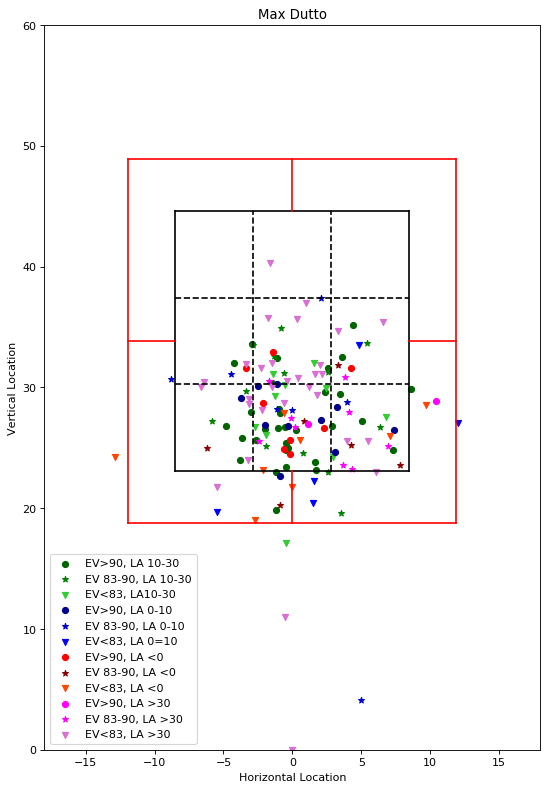

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo
Z 1,0.0,0.0,0.0,0.0,0.0
Z 2,0.7,0.3,0.0,80.7,85.8
Z 3,0.0,0.0,0.0,0.0,0.0
Z 4,0.6,0.2,0.2,84.4,93.7
Z 5,0.6,0.0,0.4,79.4,96.6
Z 6,0.4,0.4,0.1,88.1,95.4
Z 7,0.4,0.3,0.3,86.7,98.8
Z 8,0.2,0.2,0.5,87.4,98.6
Z 9,0.3,0.1,0.6,86.1,96.9


In [187]:
hstats  = HitterSummary(hx2, 'Max Dutto', 44,55, 60, 90)
hstats

In [188]:
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo
Z 1,0.0,0.0,0.0,0.0,0.0
Z 2,0.7,0.3,0.0,80.7,85.8
Z 3,0.0,0.0,0.0,0.0,0.0
Z 4,0.6,0.2,0.2,84.4,93.7
Z 5,0.6,0.0,0.4,79.4,96.6
Z 6,0.4,0.4,0.1,88.1,95.4
Z 7,0.4,0.3,0.3,86.7,98.8
Z 8,0.2,0.2,0.5,87.4,98.6
Z 9,0.3,0.1,0.6,86.1,96.9
